In [0]:
%tensorflow_version 2.x

In [3]:
import numpy as np
import pandas as pd 
import nltk
import re

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from os import path

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import  Dense, Activation, Dropout,Bidirectional, GlobalMaxPool1D,BatchNormalization, Embedding,LSTM, Flatten


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
sw = stopwords.words('english')
stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer() 

swNot = ['no', 'nor', 'not', 'don', "don't", 'ain', 'aren', "aren't",
         'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't",
         'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
         "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
         "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
         "wasn't", 'weren', "weren't", "won't", 'wouldn',"wouldn't"]

for word in swNot:
   sw.remove(word)

print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

In [0]:
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

In [0]:
def clean_text(x):
    x = str(x)
    x = x.lower()
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ') 
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
   
    return x

def stopwords1(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

def lemm(text):    
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text) 

def text_processing(X):
    X=X.apply(stopwords1)
    X=X.apply(clean_text)
    X=X.apply(stemming)
    X=X.apply(lemm)
    return X

In [15]:
fake_dataset_url = 'https://raw.githubusercontent.com/Bangkit-2-Jakarta-Team/Fake-News-Detection/master/Datasets/Fake.csv'
true_dataset_url='https://raw.githubusercontent.com/Bangkit-2-Jakarta-Team/Fake-News-Detection/master/Datasets/True.csv'

df_fake = pd.read_csv(fake_dataset_url)
df_true = pd.read_csv(true_dataset_url)
df_fake['is_true'] = 0
df_true['is_true'] = 1

# make ratio of true and fake dataset is same
df_length = min(len(df_fake), len(df_true))
df_fake = df_fake[:df_length]
df_true = df_true[:df_length]

#Merge two dataframe into one
df_data = pd.concat([df_fake,df_true])

#Randomizing data sequence to scatter data
df_data = shuffle(df_data).reset_index(drop=True)

#Showing sample
df_data.sample(5)

,title,text,subject,date,is_true
40190,"North Korea's wounded defector 'nice guy,' lik...",SEOUL (Reuters) - North Korea s latest defecto...,worldnews,"November 23, 2017",1
31499,(VIDEO) Elitist Media Stoops To New Low Attack...,The elitist media is exposing its bias and dis...,politics,"Sep 24, 2015",0
19173,New U.S. government rules restrict travel and ...,WASHINGTON/HAVANA (Reuters) - The U.S. governm...,worldnews,"November 8, 2017",1
12871,WOW! WIGGLE ROOM: Great Ad Hammers Clinton On ...,This ad by the Republican Party nails Hillary ...,politics,"Feb 21, 2016",0
5619,COMMANDER IN CHIEF APPROVED RACISM? U.S. Milit...,Do we even need to ask how 16 white West Point...,left-news,"May 11, 2016",0


In [0]:
x = df_data['title']
y = df_data['is_true']

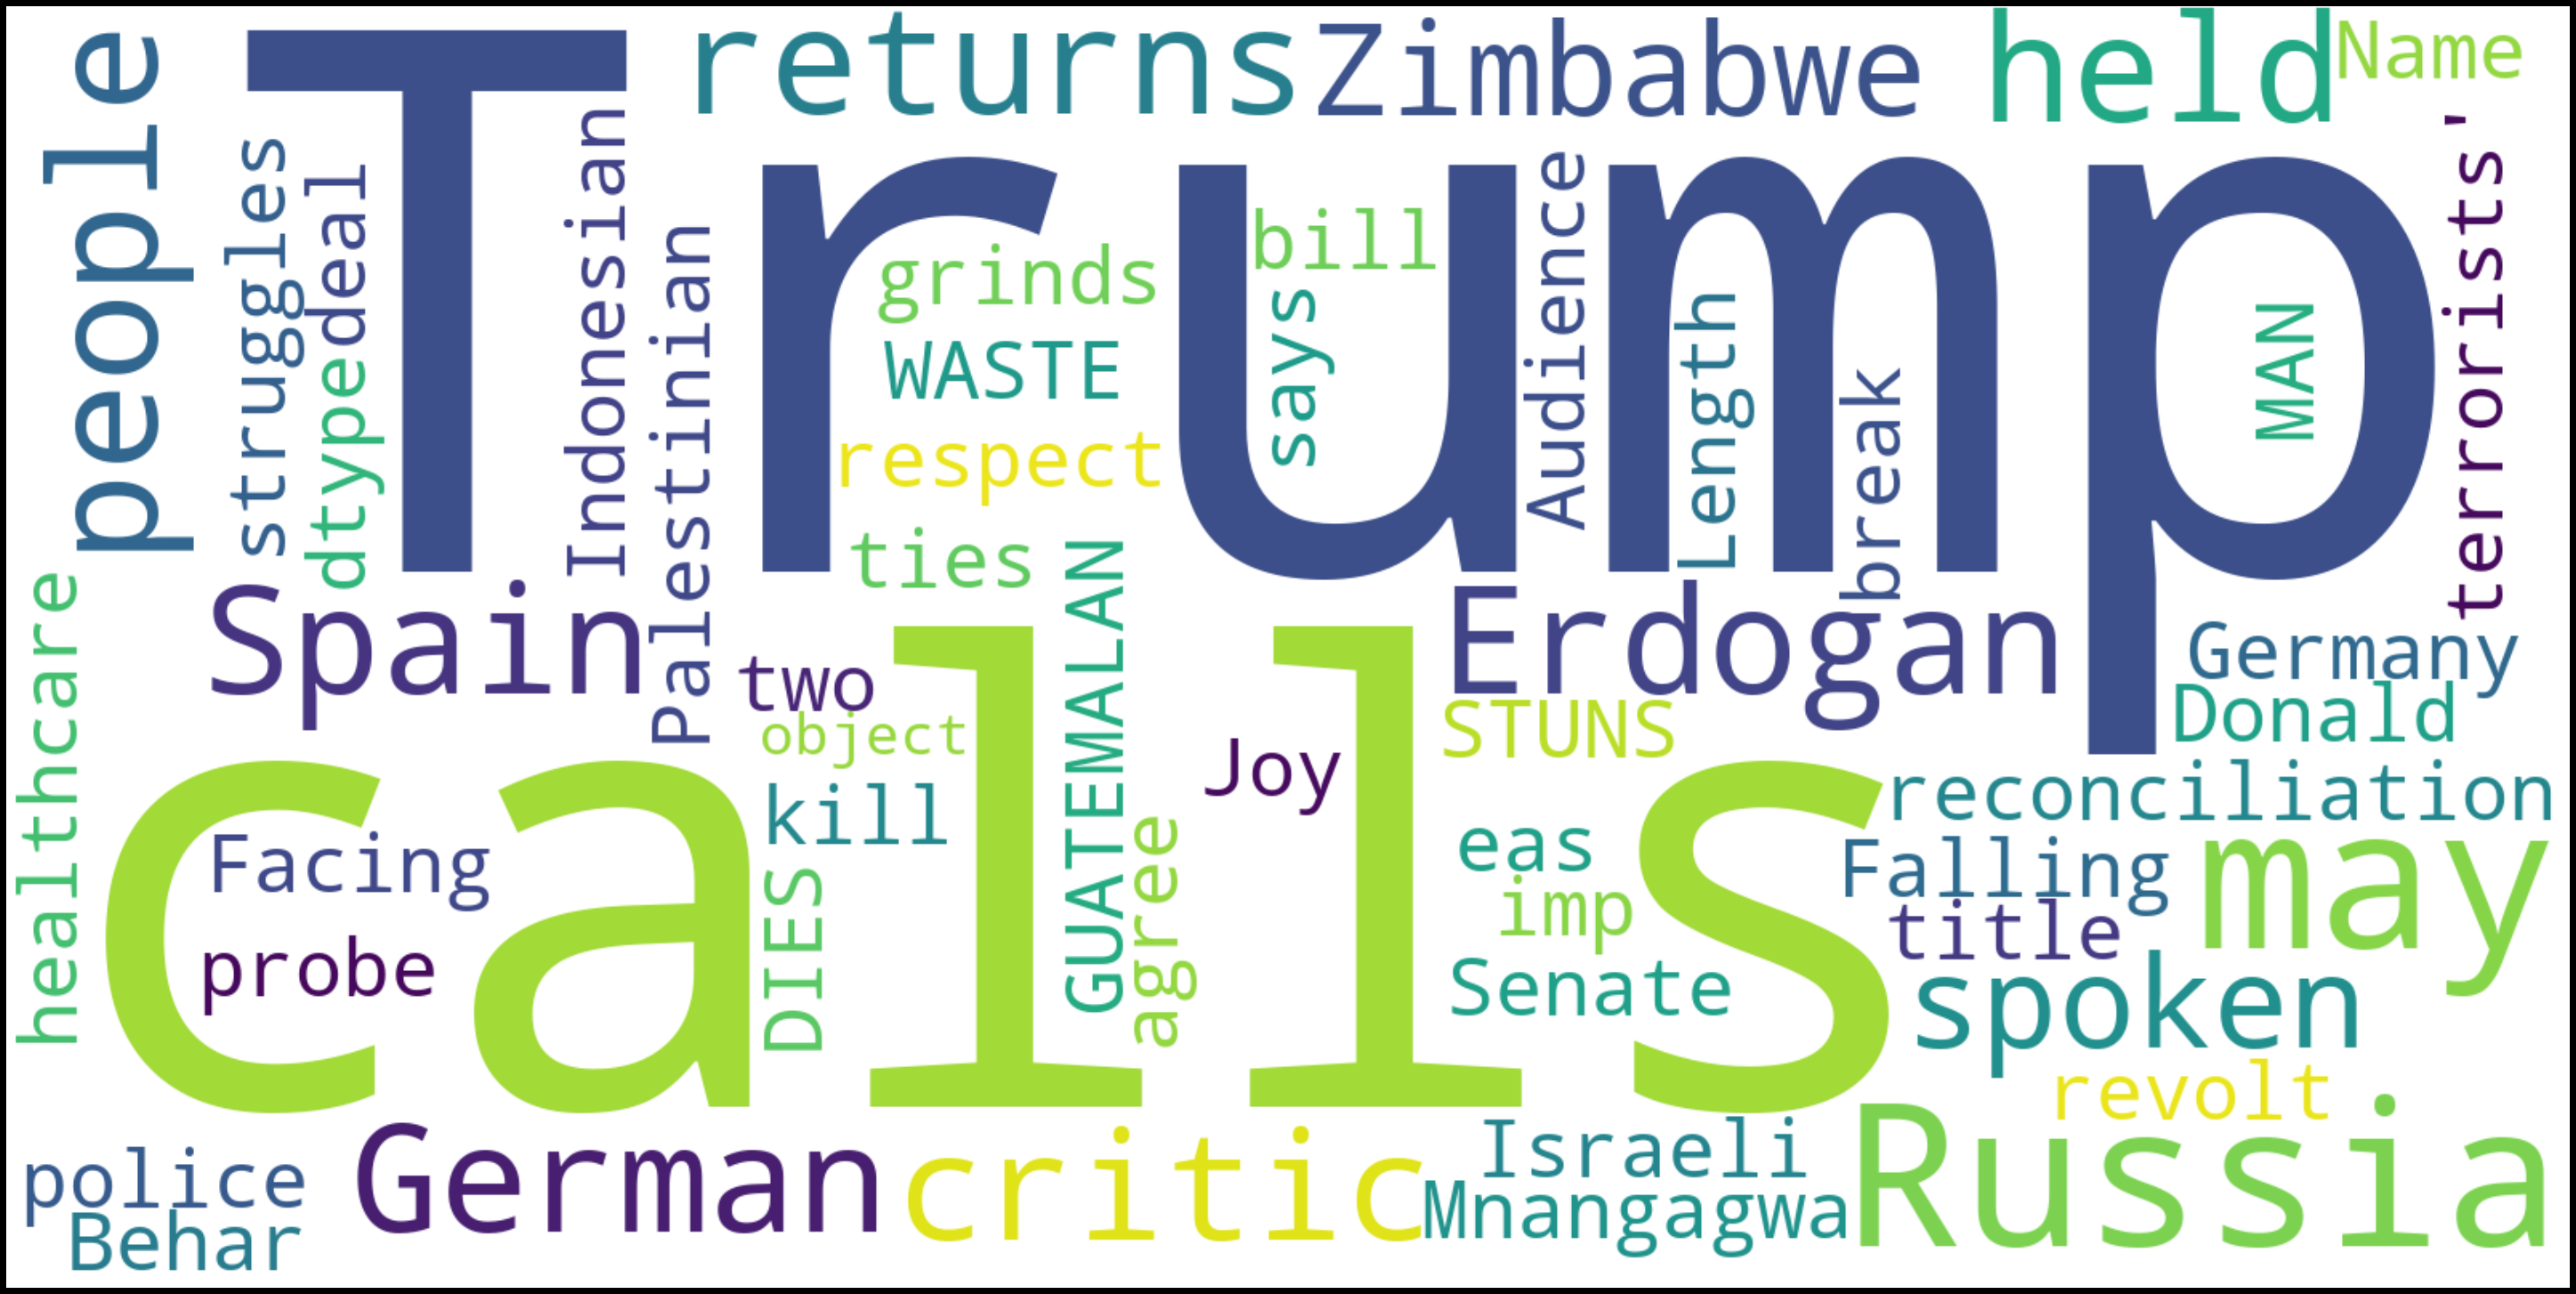

In [17]:
#Counting Unique word to generate WordCloud
text_wc = x
wordcloud= WordCloud(
    width =1600,
    height = 800,
    background_color='white',
    stopwords=STOPWORDS).generate(str(text_wc))
fig = plt.figure(
    figsize = (40,30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [0]:
#Clean data using text_processing() function
clean_x = text_processing(x)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(clean_x, y, test_size=0.3, random_state = 42)

In [37]:
# Techniques Data
y_test_temp = y_test
max_words = 2000

# cast text to token
tokenize = text.Tokenizer(num_words=max_words)
tokenize.fit_on_texts(x_train) # only fit on train
x_train = tokenize.texts_to_sequences(x_train)
x_test = tokenize.texts_to_sequences(x_test)

# encode label
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

max_sequences= 300
x_train=pad_sequences(x_train,maxlen=max_sequences)
x_test=pad_sequences(x_test,maxlen=max_sequences)

[[   0    0    0 ...  263 1425  200]
 [   0    0    0 ...  606  253  373]
 [   0    0    0 ...  454  597  165]
 ...
 [   0    0    0 ...  944  568    3]
 [   0    0    0 ...  478  446 1216]
 [   0    0    0 ...  273  374    3]]


In [38]:
#LSTM DTS
embed_size = 128

model = Sequential()
model.add(Embedding(max_words,embed_size,input_length=max_sequences))
model.add(Bidirectional((LSTM(64,return_sequences = True,recurrent_dropout=0.5))))
model.add(Dropout(0.6))
model.add(GlobalMaxPool1D())
model.add(Dense(48, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(len(y.unique()), activation="softmax"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          256000    
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          98816     
_________________________________________________________________
dropout (Dropout)            (None, 300, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 48)                6192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 9

In [39]:
batch_size = 64
epochs = 10

callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1),]
    
history3 =model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 393s 1s/step - loss: 0.2519 - accuracy: 0.8957 - val_loss: 0.2621 - val_accuracy: 0.9313
Epoch 2/10
375/375 [==============================] - 390s 1s/step - loss: 0.1278 - accuracy: 0.9525 - val_loss: 0.2169 - val_accuracy: 0.9365
Epoch 3/10
375/375 [==============================] - 391s 1s/step - loss: 0.1031 - accuracy: 0.9625 - val_loss: 0.1649 - val_accuracy: 0.9425
Epoch 4/10
375/375 [==============================] - 392s 1s/step - loss: 0.0845 - accuracy: 0.9686 - val_loss: 0.1668 - val_accuracy: 0.9391
Epoch 5/10
375/375 [==============================] - 391s 1s/step - loss: 0.0723 - accuracy: 0.9732 - val_loss: 0.1564 - val_accuracy: 0.9375
Epoch 6/10
375/375 [==============================] - 392s 1s/step - loss: 0.0591 - accuracy: 0.9776 - val_loss: 0.1558 - val_accuracy: 0.9376
Epoch 7/10
375/375 [==============================] - 392s 1s/step - loss: 0.0515 - accuracy: 0.9798 - val_loss: 0.1594 - val_accuracy: 0.9400

In [40]:
accr1 = model.evaluate(x_test,y_test)

402/402 [==============================] - 42s 104ms/step - loss: 0.1748 - accuracy: 0.9427


In [42]:
print('AKURASI DARI LSTM \nTest set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))

AKURASI DARI LSTM 
Test set
  Loss: 0.175
  Accuracy: 0.943
